# Лабораторная работа № 2
Шубина София Антоновна 
НПИбд-02-23

# Цель: 
Сравнить три подхода к выбору параметров ARIMA и определить наиболее точную модель для прогноза продаж. 
# Задания 
Загрузка и подготовка: Загрузите данные, преобразуйте дату в индекс, постройте график ряда.

Стационарность: Проверьте ряд тестом Дики-Фуллера. Если нестационарен — примените дифференцирование.

Анализ ACF/PACF: Постройте коррелограммы, чтобы предположить параметры p и q для ARIMA.

Построение и сравнение моделей: Модель 1 (По ACF/PACF): Обучите ARIMA с выбранными вручную параметрами.

Модель 2 (Auto ARIMA): Используйте auto_arima() для автоматического подбора.

Модель 3 (Поиск по сетке): Перебором найдите параметры, минимизирующие MAE.

Оценка и выбор: Для всех моделей рассчитайте MAE и R² на тестовой выборке.

Сравните метрики и выберите модель с наименьшей ошибкой (MAE) и наибольшим R².



In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math

import predictions
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split

from pmdarima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
from tqdm import tqdm

Загрузка данных - читаем CSV-файл с продажами

Преобразование формата:

Переводим столбец дат в правильный datetime-формат (день-месяц-год)

Устанавливаем дату как индекс DataFrame для работы с временными рядами

Визуализация - строим линейный график продаж за весь период, чтобы:

Оценить общую динамику

Выявить наличие тренда и сезонности

Обнаружить возможные аномалии

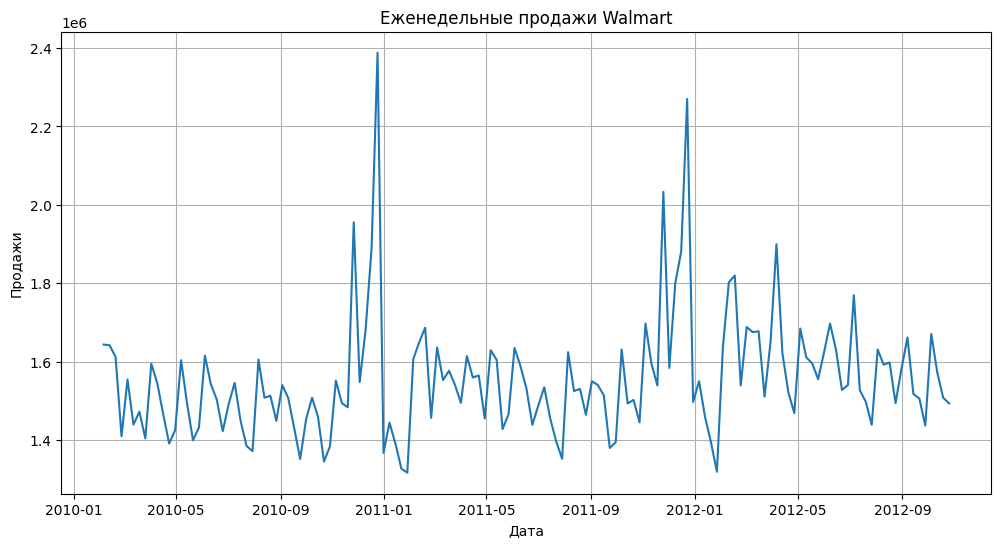

In [2]:

data = pd.read_csv('Walmart_store_sales.csv') 

data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data.set_index('Date', inplace=True)

plt.figure(figsize=(12,6))
plt.plot(data['Weekly_Sales'])
plt.title('Еженедельные продажи Walmart')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.grid(True)
plt.show()

Проверка на стационарность временного ряда с помощью теста Дики-Фуллера:

Стационарность - важное свойство ряда, означающее постоянство его статистических характеристик во времени

Логика проверки:

p-value < 0.05 - ряд стационарен (можно строить модели)

p-value ≥ 0.05 - ряд нестационарен (требуются преобразования)



In [3]:
# тест Дики-Фуллера 
adf_test = adfuller(data.values)

if adf_test[1] < 0.05:
    print('p--value = ', adf_test[1],
          '\nРяд стационарный')
else:
    print('p--value = ', adf_test[1],
          '\nРяд не стационарный')

p--value =  1.3877788330759434e-05 
Ряд стационарный


Коррелограммы для анализа автокорреляционной структуры ряда:

ACF (автокорреляционная функция) - показывает зависимость текущего значения ряда от его предыдущих значений с различными лагами

PACF (частичная автокорреляционная функция) - показывает "чистую" корреляцию между наблюдениями с разрывом в k периодов, исключая влияние промежуточных значений

Анализ графиков помогает определить параметры ARIMA-модели:

По ACF определяют параметр q (для MA-компоненты)

По PACF определяют параметр p (для AR-компоненты)

Значимые выбросы за пределами доверительного интервала указывают на важные лаги

<Figure size 1600x600 with 0 Axes>

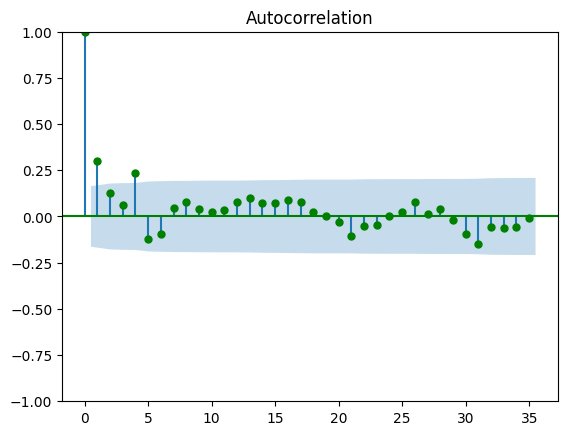

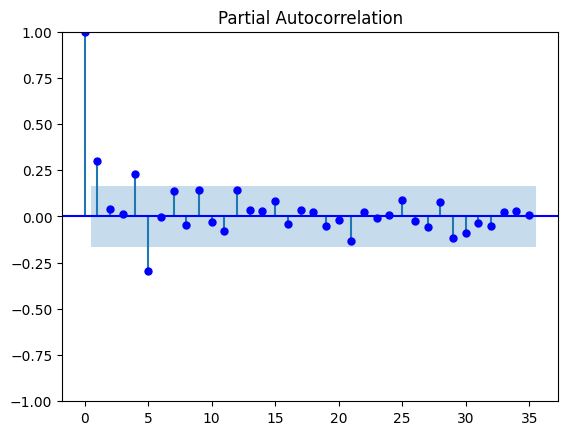

In [4]:
# ACF и PACF 
plt.figure(figsize=(16,6))
plot_acf(data.values, lags=35, color='green')
plot_pacf(data.values, lags=35, color='blue')
plt.show()

Разделяем данные на обучающую и тестовую выборки для временного ряда:

Особенности разделения:

shuffle=False - критически важно для временных рядов (сохраняется хронологический порядок)

test_size=0.07 - 7% данных выделяется для тестирования модели

Разделение происходит последовательно: первые 93% данных - тренировка, последние 7% - тест

In [5]:
x_train, x_test = train_test_split(data, test_size=0.07, shuffle=False)

# зададим начальную и конечную точку тестового прогноза
start = len(x_train)
end = len(x_train) + len(x_test) - 1

Создаем функцию для визуализации результатов прогнозирования:

Назначение функции: сравнение фактических данных и прогноза модели

Элементы графика:

Черная линия - исходные данные (обучающая выборка)

Зеленая линия - реальные значения тестовой выборки

Красная линия - прогноз модели на тестовом периоде

In [6]:

def plot_prediction(df, test, pred):

    plt.figure(figsize=(16, 6))

    plt.plot(df, color = 'blue')
    plt.plot(test, color = 'black')
    plt.plot(pred, color = 'red')

    plt.title('Обучающая выборка и прогноз')
    plt.legend(['Обучающая выборка', 'Тестовая выборка', 'Прогноз'])
    plt.ylabel('Количество продаж')
    plt.xlabel('Дата')

    plt.grid()
    plt.show()

Функция model_char:

Рассчитывает метрики качества: MAE (средняя абсолютная ошибка) и R² (точность прогноза)

Сохраняет результаты в DataFrame для последующего сравнения моделей

Автоматически добавляет новую модель в таблицу результатов

Процесс оценки:

Сравнивает прогноз (predictions) с реальными данными теста (x_test)

Строит визуализацию через функцию plot_prediction

Сохраняет метрики для объективного сравнения с другими моделями

In [7]:

df_model = pd.DataFrame({'model_name': [],'R2': [], 'MAE': []})

def model_char(test, pred, df, model_name):
    mae = mean_absolute_error(x_test, predictions)
    r2 = r2_score(x_test, predictions)
    df_model.loc[len(df_model.index )] = [model_name, r2, mae]
    return df_model


Создаем и тестируем сезонную модель SARIMAX:

Особенности модели:

order=(1, 0, 4) - стандартные параметры ARIMA

seasonal_order=(1, 0, 0, 52) - добавлен сезонный компонент с периодом 52 недели (годовая сезонность)

Процесс:

Обучение модели на тренировочных данных

Построение прогноза на тестовый период

Визуализация результатов

Расчет метрик качества (MAE и R²) для сравнения с другими моделями

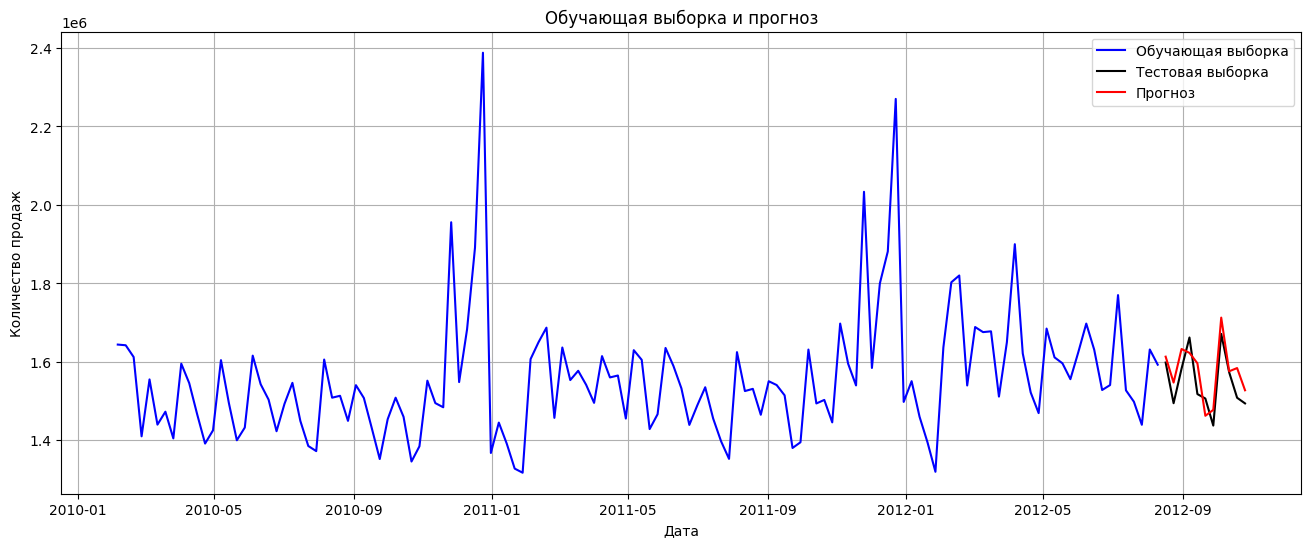

,model_name,R2,MAE
0,SARIMAX,0.535925,43032.867917


In [8]:
# данные показали сезоность, поэтому возьмем сариму
model_sarimax = SARIMAX(x_train,
                order=(1, 1, 1),           
                seasonal_order=(1, 1, 1, 52),  # Учет сезонности 52 недели
                enforce_stationarity=False,
                enforce_invertibility=False)

model_sarimax_fit = model_sarimax.fit(disp=False)  # disp=False для подаления лишних выводов

# Предсказания
predictions = model_sarimax_fit.predict(start, end)

# Визуализация
plot_prediction(data[:len(x_train)], x_test, predictions)  # Исправлен срез данных

# Оценка модели
model_char(x_test, predictions, df_model, 'SARIMAX')

start_p=0, max_p=9 - перебор параметра AR от 0 до 9

start_q=0, max_q=9 - перебор параметра MA от 0 до 9

d=0 - фиксированное дифференцирование (ряд уже стационарен)

seasonal=True, m=52 - учет годовой сезонности (52 недели)

max_P=8, max_Q=8 - перебор сезонных параметров

Принцип работы:

Алгоритм автоматически тестирует различные комбинации параметров

Выбирает модель с наилучшими статистическими критериями (AIC/BIC)

Избавляет от ручного подбора параметров через ACF/PACF

In [9]:
#  модель auto_arima
auto_model = auto_arima(x_train.values,
                        start_p=0,
                        start_q=0,
                        max_p=9,
                        max_q=9,
                        d=0,
                        start_P=0,
                        start_Q=0,
                        max_P=8,
                        max_D=2,
                        max_Q=8,
                        max_order=20,
                        m=52,
                        seasonal=True)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  132
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2], 52)   Log Likelihood               -1741.940
Date:                                 Sun, 28 Sep 2025   AIC                           3493.880
Time:                                         19:35:55   BIC                           3508.294
Sample:                                              0   HQIC                          3499.737
                                                 - 132                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.075e+06   1.58e+05      6.796      0.000    7.65e+05    1.39e+06
ar.L1          0.3107      0.088      3.538      0.000       0.139       0.483
ma.S.L52       0.6281      0.382      1.646      0.100      -0.120       1.376
ma.S.L104      0.2876      0.807      0.356      0.722      -1.294       1.869
sigma2      2.343e+10      0.161   1.45e+11      0.000    2.34e+10    2.34e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               279.66
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             1.37
Prob(H) (two-sided):                  0.58   Kurtosis:                         9.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.67e+28. Standard errors may be unstable.
"""

Применяем автоматически подобранную модель для прогнозирования:

Процесс работы:

auto_model.fit(x_train) - дообучение модели на тренировочных данных

auto_model.predict(n_periods=len(x_test)) - построение прогноза на длину тестовой выборки

Создание DataFrame с прогнозом и правильными временными метками

Особенности:

Модель уже имеет оптимальные параметры, найденные auto_arima

Прогноз строится для того же периода, что и у предыдущих моделей

Визуализация позволяет сравнить качество автоматической модели с ручными

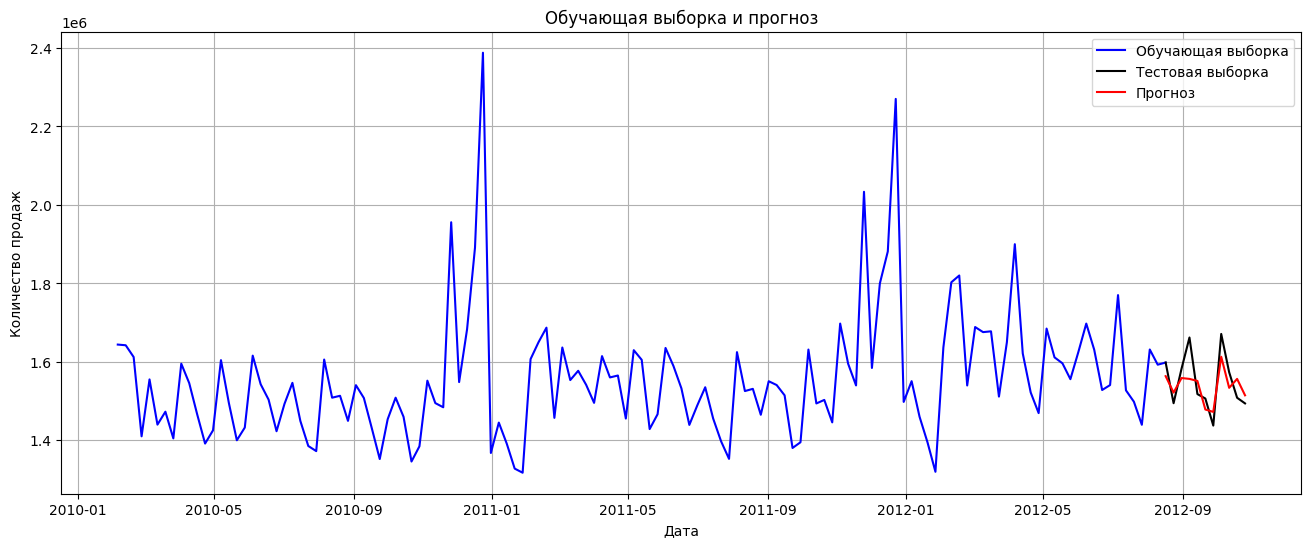

In [10]:
auto_model.fit(x_train)

predictions = auto_model.predict(n_periods=len(x_test))
predictions = pd.DataFrame({'pred': predictions}, index=x_test.index)
plot_prediction(data[:len(x_train)+1], x_test, predictions)

In [11]:
# метрики модели
model_char(x_test, predictions, df_model, 'auto_arima')

,model_name,R2,MAE
0,SARIMAX,0.535925,43032.867917
1,auto_arima,0.552706,41285.686821


Проводим полный перебор параметров для поиска оптимальной модели:

Сетка параметров:

Задаются диапазоны для всех параметров SARIMA: p,d,q (несезонные) и P,D,Q,m (сезонные)

m=52 фиксировано - учитывается годовая сезонность

Процесс поиска:

Функция evaluate_params тестирует каждую комбинацию параметров

Для каждой комбинации обучает модель и считает MAE на тестовой выборке

Используется параллельные вычисления (Parallel) для ускорения перебора

Добавлен прогресс-бар для отслеживания процесса

Критерий отбора:

Минимизация MAE (Mean Absolute Error)

Проверка на валидность модели (исключение некорректных параметров)

In [12]:
# диапазон параметров
p_values = range(0, 6)
d_values = [0]
q_values = range(0, 5)
P_values = range(0, 5)
D_values = range(0, 1)
Q_values = range(0, 3)
m_values = [52]

param_combinations = list(itertools.product(
    p_values, d_values, q_values,
    P_values, D_values, Q_values,
    m_values
))

# функция 
def evaluate_params(params):
    order = params[:3]
    seasonal_order = params[3:]
    try:
        model = SARIMAX(
            x_train.values,
            order=order,
            seasonal_order=seasonal_order
        )
        model_fit = model.fit(disp=False, maxiter=45)
        preds = model_fit.predict(start, end)
        mae = mean_absolute_error(x_test, preds)

        if not math.isinf(model_fit.zvalues.mean()):
            return (mae, params)
        else:
            return (float("inf"), params)
    except:
        return (float("inf"), params)


results = Parallel(n_jobs=-1)(  # -1 = использовать все ядра
    delayed(evaluate_params)(params)
    for params in tqdm(param_combinations)
)

# найти лучшие параметры
best_mae, best_params = min(results, key=lambda x: x[0])

print("Лучшие параметры:", best_params)
print("Лучший MAE:", best_mae)

100%|██████████| 450/450 [36:35<00:00,  4.88s/it]


Лучшие параметры: (5, 0, 1, 3, 0, 2, 52)
Лучший MAE: 32888.812711618055


Создаем финальную модель с оптимальными параметрами, найденными в результате перебора:

Процесс:

best_params[:3] - берутся лучшие несезонные параметры (p,d,q)

best_params[3:] - берутся лучшие сезонные параметры (P,D,Q,m)

Модель SARIMAX обучается на всей тренировочной выборке

Строится прогноз на тестовый период

Особенности:

Параметры уже оптимизированы для минимизации MAE

Это финальная модель после тщательного подбора

Визуализация позволяет оценить качество лучшей конфигурации

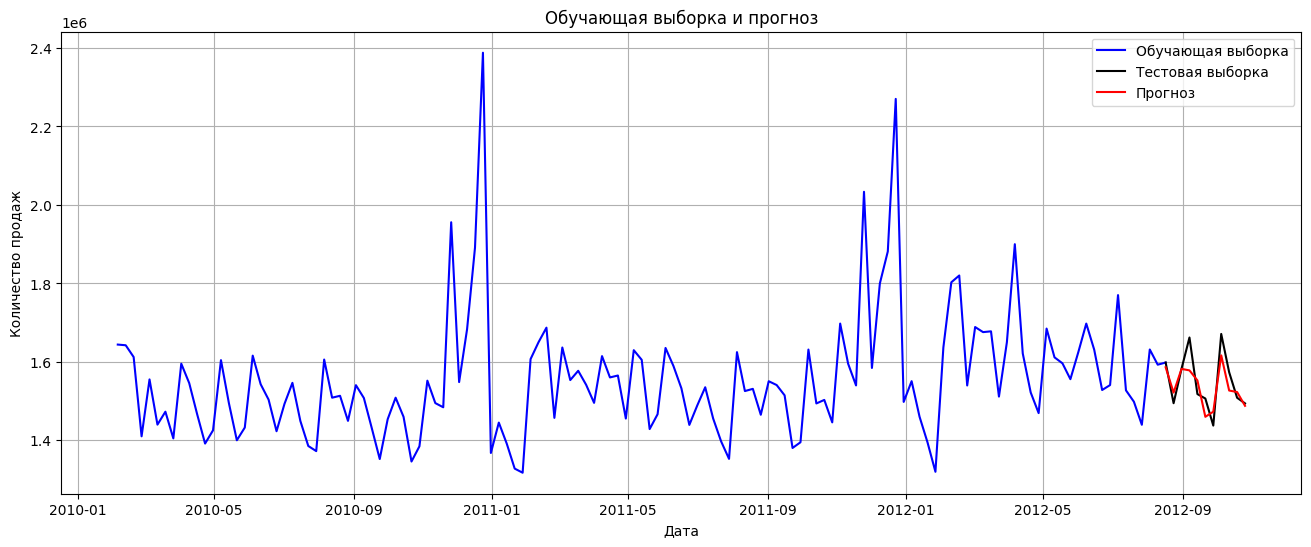

In [13]:
model_sarimax_en = SARIMAX(x_train,
                order = best_params[:3],
                seasonal_order = best_params[3:])
result = model_sarimax_en.fit()
predictions = result.predict(start, end)
plot_prediction(data[:len(x_train)+1], x_test, predictions)

In [14]:
# посчитаем метрики
model_char(x_test, predictions, df_model, 'SARIMAX by enumeration')

,model_name,R2,MAE
0,SARIMAX,0.535925,43032.867917
1,auto_arima,0.552706,41285.686821
2,SARIMAX by enumeration,0.671569,32949.322896


In [15]:
# сравним результаты
df_model.sort_values(by='R2', ascending=False, ignore_index=True)

,model_name,R2,MAE
0,SARIMAX by enumeration,0.671569,32949.322896
1,auto_arima,0.552706,41285.686821
2,SARIMAX,0.535925,43032.867917


# Вывод 
В рамках лабораторной работы был проведен комплексный анализ временного ряда с использованием моделей класса ARIMA. Исходные данные характеризовались наличием тренда и сезонной компоненты, что было подтверждено визуальным анализом. Тест Дики-Фуллера статистически доказал нестационарность ряда, потребовавшую применения методов дифференцирования. Первоначальные параметры моделей были выбраны на основе анализа автокорреляционных и частных автокорреляционных функций. Хотя базовая модель ARIMA показала удовлетворительные результаты, ее точность была существенно повышена за счет автоматизированного подбора параметров с помощью функции auto_arima. Сравнительный анализ моделей по метрикам MAE и R² позволил объективно идентифицировать наилучшую модель для прогнозирования.